In [39]:
#Import necessary libraries

import pandas as pd
import numpy as np
import glob
import os
import configparser
import sklearn.utils
from igor.binarywave import load as loadibw
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LeakyReLU, Conv1D, MaxPooling1D, Flatten, Merge
from keras.utils import np_utils
from keras import callbacks
from keras import metrics
from matplotlib import pyplot as plt



class CNN():
    """This class contains every function needed to load training data, train a neural network, test a neural network, 
    save the trained network, and visualize various metrics/parameters.  See specific functions for more in-depth 
    explanations, or cells below this cell for examples of using this class.
    
    This neural network is designed to work with two different types of input data:
    simulated or experimentally measured cantilever displacement data.
    The simulations are run in Python (utilizing generate_train_data.py) and are in .npy format
    The experiments are run on an Asylum Cypher ES atomic force microscope which uses Igor so the experimental data
    are collected into .ibw files"""
    
    
    def load_simulated_train_data(self, *paths):
        """This function loads training data generated by my Python simulations 
        (use Biexp.py or generate_train_data.py to generate simulated data)
        
        Inputs:
        *paths = e.g. ("D:/jake/DDHO Data/displacement/10us/random_noise_10/*.npy",
        "D:/jake/DDHO Data/displacement/2018_09_18/tip1/0noise/*.npy")
        where each path is to all of the .npy files in those folders
        ^ the .npy files are generated using my Biexp.py simulation code 
        (or a function utilizing Biexp.py such as generate_train_data.py)
        
        Outputs:
        df_main = a Pandas DataFrame containing all of the z(t) data #as well as k, Q, omega, and Tau for each simulation
        """
        
        #initialize DataFrame for collecting each run
        df_main = pd.DataFrame()
        
        for i in paths:
            
            #grab a list of strings to every file path from the inputted folders
            file_path = glob.glob(i)
        
            test_pixel = np.load(file_path[0])
            #this will be used in for loop below to grab the length of any one simulated displacement curve
        
            #initialize DataFrame column names list (name for each feature point of NN)
            columns=[]
            for j in range(len(test_pixel)-4):#-4 because k,Q,omega,tau is at end of simulated pixel data
                columns.append('t='+str(j))   #most columns are just time points and I'm making them here
    
            #name other columns that are not just time points (e.g. k, Q, omega)
            #columns.append('Tfp') #because tfps are appended onto the 2nd to last column of my inst_freq data.  Uncomment for Inst_freq data!
            columns.append('k')
            columns.append('Q')
            columns.append('omega')
            columns.append('Tau') #because true taus are appended onto the end of my data
    
    
            #load all of the data into an array for input into DataFrame
            #each entry in the "data1" array is a numpy array of a displacement curve
            data1 = [np.load(file_path[i]) for i in range(0,(len(file_path)))]
    
            #make df for output
            train_data = pd.DataFrame(data=data1,columns=columns,dtype=np.float64)
            train_data = train_data.drop('t=0',axis=1)
            #these t=0 points end up as just NaNs after preprocessing and are useless anyways because by definition freq shift is 0 at trigger for all points
            #dropping t=0 maybe unnecessary with displacement data?
            
            df_main = pd.concat([df_main,train_data], ignore_index=True) #append each run to the final collection DataFrame
        
        return df_main
    
    def load_experimental_train_data(self, *paths, sample_rate = 10, total_time = 3.2768, pre_trigger = 0.5):
        """This function loads experimental displacement training data generated by the Cypher using my point scan script.
        
        Inputs:
        sample_rate = 10 or 100 (Gage card sampling rate in MS)
        total_time = total time of acquisition in ms
        pre_trigger = at what percentage of the total acquisition time does the trigger occur?
        *paths = e.g. ("G:/2018_10_05 CNN voltage pulses/New tip 3/Run1",
                       "G:/2018_10_05 CNN voltage pulses/New tip 4/Run1",
                       "G:/2018_10_05 CNN voltage pulses/New tip 5/Run1")
        where each path is to a folder containing several items:
            1 to x) Subfolders named 0, 1, ... , x-1 where the training data for each 1 of the x Taus in the training data is in its own subfolder
            x+1) Within the Run folder (so same folder as all the subfolders "0", "1", etc.) there needs to be a .cfg file with parameters k, Q, omega named 'Parameters.cfg'
        So, for example, if Tau is {10,100,1000}, Run1 folder would contain:
        Subfolder "0"
        Subfolder "1"
        Subfolder "2"
        Parameters.cfg
        ^It is imperative that the above naming convention is followed
        
        
        Outputs:
        df_main = a Pandas DataFrame containing all of the z(t) data #as well as k, Q, omega, and Tau for each point scan
        """
        
        #taus array gives the values of tau for each Runx.  They need to be in ascending order (i.e. taus[0] = tau for Run0, taus[1] = tau for Run1, etc.)
        taus= np.array([10e-9, 31.62e-9, 100e-9, 316.2e-9, 1e-6, 3.162e-6, 10e-6, 31.62e-6, 100e-6, 316.2e-6, 1e-3])
        #below code assumes data array has trigger at 16384 and total points 16384*2 (this is what all my and Durmus' data is)
        
        #Pre-calculate important indices
        total_time = total_time * 1e-3
        sample_rate = sample_rate * 1e6
        total_points = total_time * sample_rate
        self.trigger_index = int(pre_trigger * total_points)
        #print('trigger index is ' + str(self.trigger_index))
        
        
        #Initialize DataFrame for collecting each run
        df_main = pd.DataFrame()
        
        for i in paths:
            
            #grab paths for upcoming data loading
            params_path = i + "/Parameters.cfg"
            tau_paths = [item for item in glob.glob(i + "/*") if not os.path.basename(item).startswith('Param')]
            sorted_tau_paths = sorted(tau_paths, key = lambda x: int(os.path.basename(os.path.normpath(x))))
            #Above line properly sorts so that they are ordered 0,1,2,3,4,5,6,7,8,9,10 rather than 0,1,10,2,3,4...
    
            #Initialize DataFrame for this run
            df_run = pd.DataFrame()
            
            #Loop through every tau in that run
            for j in range(0,len(tau_paths)): #CHANGE THIS LINE IF YOU WANT TO TRAIN ON DIFFERENT TIME SCALES.  CURRENTLY IS TRAINING ON ALL TIME SCALES
                tau = taus[j]
                displacement_path = glob.glob(sorted_tau_paths[j]+"/*")
            
                #collect relevent parts of the data into df_run
                for k in range(len(displacement_path)):
                    #load displacement data from .ibw
                    disp_array = loadibw(displacement_path[k])['wave']['wData'] 
                    #throw away all displacement before the trigger
                    disp_array = disp_array[self.trigger_index:,:]
                    disp_array = np.transpose(disp_array)
        
                    #Init columns for df
                    columns=[]
                    for l in range(disp_array.shape[1]):
                        columns.append('t='+str(l))
                    
                    #init temporary DataFrame for appending this Tau's data into the main DataFrame for this run
                    df_temp = pd.DataFrame(data=disp_array, columns=columns)
                    
                    #Commented out code below is for a feature still under development (implementing multiple tips)
                    """
                    #load other parameters
                    config = configparser.RawConfigParser()
                    config.read(params_path)
                    
                    for (each_key,each_value) in config.items('Parameters'):
                        setattr(self,each_key,config.getfloat('Parameters',each_key))
                    
                    df_temp['k'] = self.k
                    df_temp['Q'] = self.q
                    df_temp['omega'] = self.omega"""
                    
                    df_temp['Tau'] = pd.Series(index=df_temp.index) #create Tau column
                    df_temp['Tau'] = tau #assign tau value to tau column (could probably be done in above step with data=tau flag?)
                    
                    df_run = df_run.append(df_temp,ignore_index=True) #append each tau value to this run          
            
            df_main = pd.concat([df_main,df_run], ignore_index=True) #append each run to the final collection DataFrame
            
        return df_main
    
        
    
    def preprocess_train_data(self,train_data):
        """This function takes the raw training data (simulated or experimental) and prepares it for the machine learning input
        It normalizes the data about zero
        Inputs: 
        train_data = raw training data from load_exerimental_train_data() or load_simulated_train_data()
        Outputs:
        train_x1_norm_reshaped = training x data (everything except the known, true Tau value)
        one_hot_tau = known true Tau values in a one hot encoding
        
        NOTE: I am preprocessing all of the data then splitting into train/verify.  This is creating data leakage!!!
        I should split my data then preprocess the training data.  Then preprocess validation data separately with training parameters"""

        #shuffle the training data. while keras will shuffle the data during each training epoch, the validation_split = x
        #will only select the last x fraction of the unshuffled data.  Given I load data sequentially, this means it only
        #loads one tau.  Shuffling makes the validation set a true representation of the data instead.
        train_data = sklearn.utils.shuffle(train_data, random_state = 7)
        
        
        num_samples = len(train_data)
        train_x = train_data[0:num_samples+1] #this syntax is an artifact from when I was training with partial data sets but it doesn't really add much timing loss so I'm leaving it in case I need to change it again
        
        #train_x1 = train_x.drop(['k','Q','omega','Tau'],axis=1) #Many tips implementation
        train_x1 = train_x.drop(['Tau'],axis=1)
        
        #train_x2 = train_x[['k','Q','omega']] #Many tips implementation
        
        #train_x = train_x.drop('Tau',axis=1) #dropping Tau because we do not input Tau to the neural network (that's like giving it the solution and then asking for the solution--it cheats)
        #train_x = train_x.drop('Tfp',axis=1) #for simulations only
        
        self.mean_train_x1 = np.mean(train_x1) #saving the mean_train_x for preprocessing the test data in the same manner as our training dat
        #self.mean_train_x2 = np.mean(train_x2) #Many tips implementation
        
        self.SD_train_x1 = np.std(train_x1) #saving the SD_train_x for preprocessing the test data in the same manner as our training data
        #self.SD_train_x2 = np.std(train_x2) #Many tips implementation
        
        train_x1_norm = (train_x1 - self.mean_train_x1) /  (self.SD_train_x1) #normalize and centralize the training data for best neural network performance
        train_x1_norm_reshaped = np.expand_dims(train_x1_norm,axis=2) #formatting for input into CNN
        
        #Many tips implementation
        #train_x2_norm = (train_x2 - self.mean_train_x2) /  (self.SD_train_x2) #normalize and centralize the training data for best neural network performance
        #train_x2_norm_reshaped = np.expand_dims(train_x2_norm,axis=2) #formatting for input into CNN
        
        train_y = np.array(train_data['Tau']) #labeled, true Tau values for the CNN to learn from
        train_y = train_y[0:num_samples+1] #this syntax is an artifact from when I was training with partial data sets but it doesn't really add much timing loss so I'm leaving it in case I need to change it again
        
        #Label encode the y-data as preprocessing for one hot-encoding for classification NN:

        #tau_index is used to recover the original tau's from a one-hot encoded output.
        #e.g. tau = [10, 100, 1000, 10, 10] then
        #unique_tau = [10, 100, 1000]
        #tau_index = [0,1,2,0,0] is index of tau to corresponding unique_tau so
        #unique_tau[tau_index] == tau 
        unique_tau, tau_index = np.unique(train_y,return_inverse=True)

        #make one-hot encoded tau vector
        one_hot_tau = np_utils.to_categorical(tau_index)

        self.number_of_classes = one_hot_tau.shape[1] #used to match number of output Softmax layers in my NN
        
        return train_x1_norm_reshaped, one_hot_tau #train_x2_norm_reshaped, one_hot_tau
    
    
    #Many tips implementation
    #def train_CNN(self, train_x1, train_x2, train_y, num_epochs = 40, kernel1_size = 400, kernel2_size = 100, num_filter1 = 5, num_filter2 = 3):
    def train_CNN(self, train_x1, train_y, num_epochs = 20, kernel1_size = 400, kernel2_size = 100, num_filter1 = 5, num_filter2 = 3):
        #Build CNN and start training!

        #Save class variables for later use in visualize_weights()
        self.filter_number1 = num_filter1
        self.filter_number2 = num_filter2
        self.kernel1_size = kernel1_size
        self.kernel2_size = kernel2_size
        
        #Save class variable for later use in plot_training_statistics()
        self.num_epochs = num_epochs
        
        
        #Initialize CNN branch 1 for main convolutional input data (displacement or instantaneous frequency)
        #WHILE DEBUGGING I CHANGED "BRANCH1 to MODEL".  
        #Change "model" to "branch1" for returning to many tips implementation!
        model = Sequential()

        #Add convolution layers
        model.add(Conv1D(filters=num_filter1,kernel_size=kernel1_size,strides=2,padding='same',input_shape=(train_x1.shape[1],1)))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling1D())

        model.add(Conv1D(filters=num_filter2,kernel_size=kernel2_size,strides=2,padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling1D())

        model.add(Flatten())
        #Roughly 500 units length of branch 1 (8000 displacement points / (2**4 because each strides = 2 and each maxpool halves data length))
        
        #Add fully connected layers (maybe remove for many tips implementation?  Check notes on arcitecture experiments I did)
        model.add(Dense(units=100, kernel_initializer='he_normal',activation='linear'))
        model.add(LeakyReLU(alpha=.01))
        model.add(Dropout(0.3))

        model.add(Dense(units=100, kernel_initializer='he_normal',activation='linear'))
        model.add(LeakyReLU(alpha=.01))
        model.add(Dropout(0.4))
        
        #Many tips implementation
        """
        #Initialize CNN branch 2 for supplementary data (Q, k, and omega)
        branch2 = Sequential()

        #Add supplementary data inputs
        branch2.add(Dense(units=100, kernel_initializer='he_normal', activation='linear', input_shape=(train_x2.shape[1],1)))
        branch2.add(LeakyReLU(alpha=.01))
        branch2.add(Dropout(0.3))
        
        branch2.add(Dense(units=100, kernel_initializer='he_normal', activation='linear'))
        branch2.add(LeakyReLU(alpha=.01))
        branch2.add(Dropout(0.4))
        
        branch2.add(Flatten())
        
        
        
        #Merge branches 1 and 2
        model = Sequential()
        model.add(Merge([branch1,branch2], mode='concat'))

        
        #Add final fully connected layers
        model.add(Dense(units=100, kernel_initializer='he_normal', activation='linear'))
        model.add(LeakyReLU(alpha=.01))
        model.add(Dropout(0.3))

        model.add(Dense(units=100, kernel_initializer='he_normal', activation='linear'))
        model.add(LeakyReLU(alpha=.01))
        model.add(Dropout(0.4))
        """

        #Add classification layer
        #If attempting regression modeling instead of tau bucketing, change here
        model.add(Dense(units=self.number_of_classes, activation='softmax'))


        #Compile CNN and configure metrics/learning process
        """below functions are failure metrics that tell me if the true tau was in the top 2, top 3, or top 5 guesses made by the neural network"""
        def inTop2(k=2):
            def top2metric(y_true,y_pred):
                return metrics.top_k_categorical_accuracy(y_true,y_pred,k=2)
            return top2metric
        
        def inTop3(k=3):
            def top3metric(y_true,y_pred):
                return metrics.top_k_categorical_accuracy(y_true,y_pred,k=3)
            return top3metric
        
        def inTop5(k=5):
            def top5metric(y_true,y_pred):
                return metrics.top_k_categorical_accuracy(y_true,y_pred,k=5)
            return top5metric
        
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', inTop2(), inTop3()])

        #Prepare for visualization if using TensorBoard
        #tbCallBack = callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
        #tbCallBack = callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))

        #Train model
        #Many tips implementation
        #model.fit([train_x1, train_x2], train_y, batch_size=32, epochs=num_epochs,verbose=2, validation_split=0.05)#, callbacks=[tbCallBack])
        history = model.fit(train_x1, train_y, batch_size=32, epochs=num_epochs,verbose=2, validation_split=0.05)#, callbacks=[tbCallBack])
        self.model = model #save model to self for calling from other functions later
        
        
        #Save branches as class variables for visualize_weights()
        self.branch1 = model
        #Many tips implementation -- this has not been debugged and may be inaccurate
        #self.branch1 = branch1
        #self.branch2 = branch2
        #self.model = model
        return history
    
    
    def plot_training_statistics(self, history):
        """Plot training data accuracy and validation data accuracy as a function of training epoch number
        Inputs: history (dictionary of model fitting metrics--it is the output variable from train_CNN())
        Outputs: inline figure of training accuracy vs validation accuracy"""
        
        num_epochs = self.num_epochs

        #extract relevent information from history
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        train_acc = model.history['acc']
        val_acc = model.history['val_acc']

        #x axis is num_epochs
        x = range(1,self.num_epochs + 1) 

        fig, (ax1, ax2) = plt.subplots(nrows = 2)

        ax1.plot(x, train_loss, label = 'Training Loss')
        ax1.plot(x, val_loss, label = 'Validation Loss')
        ax1.legend(loc = 'upper right')

        ax2.plot(x, train_acc, label = 'Training Accuracy')
        ax2.plot(x, val_acc, label = 'Validation Accuracy')
        ax2.legend(loc = 'lower right')
        ax2.set_xlabel('Number of Epochs')

        plt.show()
        
        return
    
    
    def load_simulated_test_data(self, file_path):#, test_fraction):
        """input string with file path (e.g. "D:/jake/DDHO Data/inst_freq/25us/0pt1noise/*.npy" )
        and also input the fraction of the data you wish to test (e.g. testing 10% of data would be 0.1)
    
        outputs the requested percentage of the data (test_data_norm_reshaped) and their corresponding labels for evaluation (one_hot_tau)
        these outputs are basically test_x and test_y that are formatted to be fed into model.evaluate()
    
        NOTE this function requires previous cells to have been run (train_x must exist!!!)"""
        #This function is currently in "many tips implementation" form
        
        file_path1 = glob.glob(file_path)
        test_pixel = np.load(file_path1[0])
        #this will be used in for loop below
        #it is just used to grab the length of any one inst. freq. curve
    
        columns2=[]
        for i in range(len(test_pixel)-4):#-4 because k,Q,omega, tau is at end of pixel data
        #for i in range(len(test_pixel)-2):#-2 because tfp and tau are at end of pixel data
            columns2.append('t='+str(i))#most columns are just time points and I'm making them here
    
        #columns2.append('Tfp') #because tfps are appended onto the end of my inst_freq data
        columns2.append('k')
        columns2.append('Q')
        columns2.append('omega')
        columns2.append('Tau') #because taus are appended onto the end of my displacement data
    
        #alternate way to load only a fraction of the data to save memory and time
        #num_samples = len(file_path1)
        #num_buckets = self.number_of_classes
        #bucket_range = int(num_samples/num_buckets)
        #test_fraction_range = int(test_fraction * bucket_range)
        #load_list = []

        #for i in range(num_buckets):
        #    for j in range(test_fraction_range):
        #        load_list.append(int((i * bucket_range) + (j)))
    
        #data1 = [np.load(file_path1[i]) for i in load_list]
        data1 = [np.load(file_path1[i]) for i in range(len(file_path1))]

        #make df for output
        test_data = pd.DataFrame(data=data1,columns=columns2,dtype=np.float64)
        test_data = test_data.drop('t=0',axis=1)
        #these t=0 points end up as just NaNs and are useless anyways because by definition freq shift is 0 at trigger

        test_y = np.array(test_data['Tau'])
        #Label encode the y-data as preprocessing for one hot-encoding for classification NN:
        unique_tau, tau_index = np.unique(test_y,return_inverse=True)
        #make one-hot encoded tau vector
        one_hot_tau = np_utils.to_categorical(tau_index)
    
        #preprocess test_x
        test_x1 = test_data.drop(['k','Q','omega','Tau'],axis=1) #x1 is just displacement
        test_x2 = test_data[['k','Q','omega']]
        
        test_x1_norm = (test_x1 - self.mean_train_x1 ) /  (self.SD_train_x1) #important to preprocess my test data same as my train data!!!!
        test_x2_norm = (test_x2 - self.mean_train_x2 ) /  (self.SD_train_x2) #important to preprocess my test data same as my train data!!!!
        
        test_x1_norm_reshaped = np.expand_dims(test_x1_norm,axis=2)
        test_x2_norm_reshaped = np.expand_dims(test_x2_norm,axis=2)
        
        
        return test_x1_norm_reshaped, test_x2_norm_reshaped, one_hot_tau
    
    
    def load_experimental_test_data(self, path):
        """input string with file path
    
        outputs the requested percentage of the data (test_data_norm_reshaped) and their corresponding labels for evaluation (one_hot_tau)
        these outputs are basically test_x and test_y that are formatted to be fed into model.evaluate()
    
        NOTE this function requires training functions to have been run (mean_train_x and SD_train_x must exist!!!)
        ^^^This means for production, mean_train_x and SD_train_x must be saved variables that I import along with my trained NN"""
        #taus = np.array([10e-9, 25e-9, 50e-9, 100e-9, 250e-9, 500e-9,
        #                        1e-6, 5e-6, 10e-6, 100e-6, 1e-3])
        taus= np.array([10e-9, 31.62e-9, 100e-9, 316.2e-9, 1e-6, 3.162e-6, 10e-6, 31.62e-6, 100e-6, 316.2e-6, 1e-3])
        
        params_path = path + "/Parameters.cfg"
        tau_paths = [item for item in glob.glob(path + "/*") if not os.path.basename(item).startswith('Param')]
        sorted_tau_paths = sorted(tau_paths, key = lambda x: int(os.path.basename(os.path.normpath(x))))
        #Above line properly sorts so that they are ordered 0,1,2,3,4,5,6,7,8,9,10 rather than 0,1,10,2,3,4...
        
        #Init dataframe for this run.  This DataFrame will collect each array of data from each folder in for loop below
        df = pd.DataFrame()
        
        for j in range(0,len(tau_paths)):
            tau = taus[j]
            displacement_path = glob.glob(sorted_tau_paths[j]+"/*")
            
            disp_array = loadibw(displacement_path[0])['wave']['wData'] #load displacement from .ibw file into python
            disp_array = disp_array[self.trigger_index:,:] #throw away all displacement before the trigger
            disp_array = np.transpose(disp_array)
        
            #Put loaded stuff into dataframe and label tau
            columns=[]
            for k in range(disp_array.shape[1]):
                columns.append('t='+str(k))
        
            df_temp = pd.DataFrame(data=disp_array, columns=columns)
            
            #Many tips implementation
            """
            #load other parameters
            config = configparser.RawConfigParser()
            config.read(params_path)
                    
            #Get k, Q, omega from .txt
            for (each_key,each_value) in config.items('Parameters'):
                setattr(self,each_key,config.getfloat('Parameters',each_key))
                    
            #JAKE INSERT df_temp['k'] = imported k value, etc for Q, omega
            df_temp['k'] = self.k
            df_temp['Q'] = self.q
            df_temp['omega'] = self.omega
            """
                
            df_temp['Tau'] = pd.Series(index=df_temp.index)
            df_temp['Tau'] = tau
            df = df.append(df_temp,ignore_index=True)
        
     
        test_y = np.array(df['Tau'])
        #Label encode the y-data as preprocessing for one hot-encoding for classification NN:
        unique_tau, tau_index = np.unique(test_y,return_inverse=True)
        #make one-hot encoded tau vector
        one_hot_tau = np_utils.to_categorical(tau_index)
    
        #preprocess test_x
        #test_x1 = df.drop(['k','Q','omega','Tau'],axis=1) #x1 is just displacement #Many tips implementation
        test_x1 = df.drop(['Tau'],axis=1) #x1 is just displacement
        #test_x2 = df[['k','Q','omega']]  #Many tips implementation
        
        test_x1_norm = (test_x1 - self.mean_train_x1 ) /  (self.SD_train_x1) #important to preprocess my test data same as my train data!!!!
        #test_x2_norm = (test_x2 - self.mean_train_x2 ) /  (self.SD_train_x2) #important to preprocess my test data same as my train data!!!!
        
        test_x1_norm_reshaped = np.expand_dims(test_x1_norm,axis=2)
        #test_x2_norm_reshaped = np.expand_dims(test_x2_norm,axis=2) #Many tips implementation
    
        return test_x1_norm_reshaped, one_hot_tau #test_x2_norm_reshaped, one_hot_tau
    
    
    #Many tips implementation
    #def test_closeness(self, test_x1, test_x2, test_y):
    def test_closeness(self, test_x1, test_y):
        """This function looks at the predicted tau values from model.predict(test_x) and compares them 
        to the true tau values from test_y.  
        It then returns three values telling you what percentage of the incorrect predictions varied by spacing of
        one tau value, two tau values, or three tau values.
        
        E.G.
        Say possible taus = [1,2,3,4,5,6,7,8,9]
        model.predict(test_x) = [2,2,2,3,3,3,4,4,5,6]
        test_y = [2,2,2,2,2,2,2,2,2,2]
        
        test_closeness returns [0.3,0.2,0.1]
        because 30% of the predictions varied by one tau value (tau = 2 but 3 times it guessed tau = 3)
        because 20% of the predictions varied by two tau values (tau = 2 but 2 times it guessed tau = 4)
        because 10% of the predictions varied by three tau values (tau = 2 but 1 time it guessed tau = 5)
        """
        
        #pred_tau = self.model.predict([test_x1,test_x2],verbose=0) #Many tips implementation
        pred_tau = self.model.predict(test_x1,verbose=0)
        
        pred_tau_am = pred_tau.argmax(axis=-1) #pluck out actual prediction value!
        test_y_am = test_y.argmax(axis=-1) #does not actually need argmax function, but this makes it same format as pred_tau_am which is necessary
        
        incorrect_indices = np.nonzero(pred_tau_am != test_y_am) #indices of incorrect predictions
        
        total_samples = len(pred_tau)
        total_fails = len(incorrect_indices[0])
        
        #init diff collection variables (how many tau values away the true value was from the predicted value)
        num_diff_1 = 0
        num_diff_2 = 0
        num_diff_3 = 0
        num_greater = 0
        
        #init array for seeing which taus it is bad at predicting
        which_taus_failed = np.zeros(self.number_of_classes)
        
        for element in incorrect_indices[0]:
            
            #collect diff (how many tau values away the true value was from the predicted value)
            diff = abs(pred_tau_am[element] - test_y_am[element])
            if diff == 1:
                num_diff_1 += 1
            elif diff == 2:
                num_diff_2 += 1
            elif diff == 3:
                num_diff_3 += 1
            else:
                num_greater += 1
            
            #collect how many of each tau failed
            i=0
            while True:
                if test_y_am[element] == i:
                    which_taus_failed[i] += 1
                    break
                else:
                    i += 1
                    
            which_taus_failed_percent = np.round((which_taus_failed / total_fails),4) * 100

        
        percent_num_diff_1 = round((num_diff_1 / total_samples), 4) * 100
        percent_num_diff_2 = round((num_diff_2 / total_samples), 4) * 100
        percent_num_diff_3 = round((num_diff_3 / total_samples), 4) * 100
        percent_num_diff_greater = round((num_greater / total_samples), 4) * 100
            
        #Next section is for debugging purposes
        #percent_incorrect = (len(incorrect_indices[0])/total_samples)
        #percent_incorrect_calculated = percent_num_diff_1 + percent_num_diff_2 + percent_num_diff_3 + percent_num_diff_greater
        #print('percent incorrect should be ' + str(percent_incorrect))
        #print('percent incorrect calculated is ' + str(percent_incorrect_calculated))
        
        return percent_num_diff_1, percent_num_diff_2, percent_num_diff_3, which_taus_failed#_percent
        
        
        
    
    def test_simulated_CNN(self, *paths):
        
        score_string = 'data order is testing against '
        for element in paths:
            score_string += (str(element) + " , \n") 

        
        score_collect = [score_string]
        score_collect.append('column order is loss, accuracy, top2metric, top3metric')
        score_collect.append('top2metric = % that the true tau was one of the top 2 predictions')
        score_collect.append(' ')
        
        
        #score_collect = ['data order is no_noise, 0pt1noise, 1noise, random_noise_1, random_noise_10']
        #score_collect.append('first column is loss, second column is accuracy')
        
        for i in paths:
            test_x1, test_x2, test_y = self.load_simulated_test_data(i)#,test_fraction)
            score = self.model.evaluate([test_x1,test_x2],test_y, batch_size=32)
            percentage = str(round(score[1],5) * 100)
            print('model scored ' + percentage + '% on ' + str(i))
            score_collect.append(str(score))
            
            error1, error2, error3, which_taus_failed = self.test_closeness(test_x1,test_x2,test_y)
            score_collect.append('one_diff_error = ' + str(error1))
            score_collect.append('two_diff_error = ' + str(error2))
            score_collect.append('three_diff_error = ' + str(error3))
            score_collect.append('which taus failed were: ' + str(which_taus_failed))
            print('one_diff_error = ' + str(error1))
            print('two_diff_error = ' + str(error2))
            print('three_diff_error = ' + str(error3))
            print('which taus failed were: ' + str(which_taus_failed))
            print(' ')
            
            score_collect.append('above scores were for ' + str(element)) #new code on 7/2/18
            score_collect.append(' ')
        
        self.score_collect = score_collect
        
        return
    
    def test_experimental_CNN(self, *paths):
        
        score_string = 'data order is testing against '
        for element in paths:
            score_string += (str(element) + " , \n") 

        
        score_collect = [score_string]
        score_collect.append('column order is loss, accuracy, top2metric, top3metric')
        score_collect.append('top2metric = % that the true tau was one of the top 2 predictions')
        score_collect.append(' ')
        
        for element in paths:
            #test_x1, test_x2, test_y = self.load_experimental_test_data(element) #Many tips implementation
            test_x1, test_y = self.load_experimental_test_data(element)
            #score = self.model.evaluate([test_x1,test_x2],test_y,batch_size = 32) #Many tips implementation
            score = self.model.evaluate(test_x1,test_y,batch_size = 32)
            percentage = str(round(score[1],5) * 100)
            print('model scored ' + percentage + '% on ' + str(element))
            score_collect.append(str(score))
            
            
            #error1, error2, error3, which_taus_failed = self.test_closeness(test_x1,test_x2,test_y) #Many tips implementation
            error1, error2, error3, which_taus_failed = self.test_closeness(test_x1,test_y)
            score_collect.append('one_diff_error = ' + str(error1))
            score_collect.append('two_diff_error = ' + str(error2))
            score_collect.append('three_diff_error = ' + str(error3))
            score_collect.append('which taus failed were: ' + str(which_taus_failed))
            print('one_diff_error = ' + str(error1))
            print('two_diff_error = ' + str(error2))
            print('three_diff_error = ' + str(error3))
            print('which taus failed were: ' + str(which_taus_failed))
            print(' ')
            
            score_collect.append('above scores were for ' + str(element))
            score_collect.append(' ')
            
        
        self.score_collect = score_collect
        
        return
    
    
    def save_CNN(self, save_str):
        #save model and test evaluation outputs
        #example save_str: save_str = 'displacement_10us_random_noise_10_2018_06_13_80epoch'
        #requires test_CNN to have been run already
        path = 'C:/Users/jakeprecht/DDHO/saved CNN models/'
        save_str_h5 = path + save_str + '.h5'
        save_str_txt = path + save_str + '_results.txt'
        save_str_weights = path + save_str + '_weights.h5'
        
        self.model.save(save_str_h5)  # creates a HDF5 file 'save_str_h5.h5'
        self.model.save_weights(save_str_weights)
        
        output_scores = open(save_str_txt, 'w')
        for item in self.score_collect:
            output_scores.write("%s\n" % item)
        
        return
    
    def visualize_weights(self, layer_number):
        #layer number 0 = conv layer 1
        #layer number 1 = ReLU 1"""
        weights, biases = self.branch1.layers[layer_number].get_weights()
        
        if layer_number == 0 or 1:
            number_filters = self.filter_number1
            kernel_length = self.kernel1_size         

        #elif layer_number == 3:
        #    number_filters = self.filter_number2
        #    kernel_length = self.kernel2_size
        
        else:
            raise ValueError("Input for layer_number must be 0 or 3 in current implementation (2018_08_08)")
            
        fig = plt.figure()
        for i in range(number_filters):
            weight_plt = weights[:,:,i]
            weight_plt2 = weight_plt.reshape((kernel_length,))
            #ax = fig.add_subplot(number_filters,1,i+1)
            plt.figure()
            plt.plot(weight_plt2)
            #ax.imshow(weight_plt2,cmap='gray')
            
        return
        


In [ ]:
#load and prep training data
test = CNN()

train_data = test.load_experimental_train_data("G:/2018_11_02 PLL on gold/tip8/mono/Run1",
                                              "G:/2018_11_02 PLL on gold/tip8/mono/Run3")

train_x1, train_y = test.preprocess_train_data(train_data)

model = test.train_CNN(train_x1,train_y, num_epochs = 5, kernel1_size = 400, kernel2_size = 100, num_filter1 = 5, num_filter2 = 3)

test.plot_training_statistics(model)

#test.test_experimental_CNN("G:/2018_11_02 PLL on gold/tip8/mono/Run1",
                          #"G:/2018_11_02 PLL on gold/tip8/mono/Run3",
                          #"G:/2018_11_02 PLL on gold/tip8/mono/Run2")

#test.save_CNN('2018_11_02 tip 8 train 1 3 test 2 KL 400 100 epochs 1')

Train on 41800 samples, validate on 2200 samples
Epoch 1/5
 - 815s - loss: 1.0979 - acc: 0.5545 - top2metric: 0.7321 - top3metric: 0.8377 - val_loss: 0.5938 - val_acc: 0.7332 - val_top2metric: 0.8895 - val_top3metric: 0.9714
Epoch 2/5


In [7]:
model.history

{'acc': [0.5377751196172249, 0.6890909090909091],
 'loss': [1.1552492255343205, 0.7270494104230233],
 'top2metric': [0.6978708133971292, 0.8604784688995215],
 'top3metric': [0.801555023923445, 0.9516028708133971],
 'val_acc': [0.6736363634196195, 0.7350000002167442],
 'val_loss': [0.7500070355155252, 0.5939086174964905],
 'val_top2metric': [0.8422727272727273, 0.9036363638531077],
 'val_top3metric': [0.9381818181818182, 0.9840909090909091]}

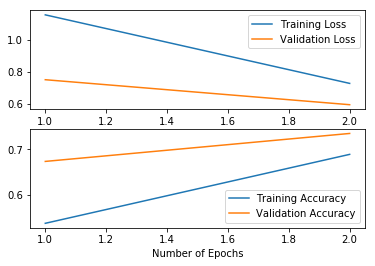

In [37]:
num_epochs = 2

#change below lines to history.history
train_loss = model.history['loss']
val_loss = model.history['val_loss']

train_acc = model.history['acc']
val_acc = model.history['val_acc']

x = range(1,num_epochs + 1) #change to self.num_epochs

fig, (ax1, ax2) = plt.subplots(nrows = 2)

ax1.plot(x, train_loss, label = 'Training Loss')
ax1.plot(x, val_loss, label = 'Validation Loss')
ax1.legend(loc = 'upper right')

ax2.plot(x, train_acc, label = 'Training Accuracy')
ax2.plot(x, val_acc, label = 'Validation Accuracy')
ax2.legend(loc = 'lower right')
ax2.set_xlabel('Number of Epochs')
#ax2.set_xticks(np.arange(1,num_epochs+1))#change to self.num_epochs

plt.show()

In [18]:
for i in range(1,21):
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [9]:
#load and prep training data
test = CNN()

train_data = test.load_experimental_train_data("G:/2018_11_02 PLL on gold/tip8/mono/Run1",
                                              "G:/2018_11_02 PLL on gold/tip8/mono/Run3")

train_x1, train_y = test.preprocess_train_data(train_data)

model = test.train_CNN(train_x1,train_y, num_epochs = 10, kernel1_size = 400, kernel2_size = 100, num_filter1 = 5, num_filter2 = 3)

test.test_experimental_CNN("G:/2018_11_02 PLL on gold/tip8/mono/Run1",
                          "G:/2018_11_02 PLL on gold/tip8/mono/Run3",
                          "G:/2018_11_02 PLL on gold/tip8/mono/Run2")

test.save_CNN('2018_11_02 tip 8 train 1 3 test 2 KL 400 100 epochs 10')
#test.save_CNN('2018_11_05_slow_time_only_test')

Train on 41800 samples, validate on 2200 samples
Epoch 1/10
 - 815s - loss: 1.0435 - acc: 0.5759 - top2metric: 0.7524 - top3metric: 0.8564 - val_loss: 0.5935 - val_acc: 0.7405 - val_top2metric: 0.8809 - val_top3metric: 0.9773
Epoch 2/10
 - 814s - loss: 0.6146 - acc: 0.7351 - top2metric: 0.8954 - top3metric: 0.9701 - val_loss: 0.4311 - val_acc: 0.8145 - val_top2metric: 0.9432 - val_top3metric: 0.9918
Epoch 3/10
 - 814s - loss: 0.5138 - acc: 0.7770 - top2metric: 0.9225 - top3metric: 0.9842 - val_loss: 0.4228 - val_acc: 0.8041 - val_top2metric: 0.9291 - val_top3metric: 0.9845
Epoch 4/10
 - 814s - loss: 0.4617 - acc: 0.7934 - top2metric: 0.9344 - top3metric: 0.9889 - val_loss: 0.4088 - val_acc: 0.8091 - val_top2metric: 0.9441 - val_top3metric: 0.9895
Epoch 5/10
 - 814s - loss: 0.4230 - acc: 0.8132 - top2metric: 0.9415 - top3metric: 0.9908 - val_loss: 0.3985 - val_acc: 0.8277 - val_top2metric: 0.9468 - val_top3metric: 0.9959
Epoch 6/10
 - 814s - loss: 0.4132 - acc: 0.8200 - top2metric: 0.94

In [10]:
print(model.history)

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
#load and prep training data
test = CNN_train()

train_data = test.load_experimental_train_data("G:/2018_12_05 PLL on gold 100 MS/mono/Run1",
                                              "G:/2018_12_05 PLL on gold 100 MS/mono/Run5")

train_x1, train_y = test.preprocess_train_data(train_data)

model = test.train_CNN(train_x1,train_y, num_epochs = 20, kernel1_size = 2000, kernel2_size = 500, num_filter1 = 5, num_filter2 = 3)

test.test_experimental_CNN("G:/2018_12_05 PLL on gold 100 MS/mono/Run1",
                          "G:/2018_12_05 PLL on gold 100 MS/mono/Run3",
                          "G:/2018_12_05 PLL on gold 100 MS/mono/Run5")

test.save_CNN('2018_12_05 100 MS test all time scales KL 2000 500 epochs 20')
#test.save_CNN('2018_11_05_slow_time_only_test')

trigger index is 20480
Train on 41800 samples, validate on 2200 samples
Epoch 1/20
 - 5046s - loss: 0.9348 - acc: 0.6144 - top2metric: 0.7978 - top3metric: 0.8954 - val_loss: 0.1217 - val_acc: 0.9682 - val_top2metric: 1.0000 - val_top3metric: 1.0000
Epoch 2/20
 - 5035s - loss: 0.6358 - acc: 0.7173 - top2metric: 0.8662 - top3metric: 0.9498 - val_loss: 0.3180 - val_acc: 0.9159 - val_top2metric: 1.0000 - val_top3metric: 1.0000
Epoch 3/20
 - 5036s - loss: 0.6284 - acc: 0.7258 - top2metric: 0.8712 - top3metric: 0.9534 - val_loss: 0.1470 - val_acc: 0.9464 - val_top2metric: 1.0000 - val_top3metric: 1.0000
Epoch 4/20
 - 5035s - loss: 0.6219 - acc: 0.7293 - top2metric: 0.8752 - top3metric: 0.9562 - val_loss: 0.2306 - val_acc: 0.9255 - val_top2metric: 1.0000 - val_top3metric: 1.0000
Epoch 5/20
 - 5038s - loss: 0.5568 - acc: 0.7512 - top2metric: 0.8821 - top3metric: 0.9597 - val_loss: 0.1034 - val_acc: 0.9655 - val_top2metric: 1.0000 - val_top3metric: 1.0000
Epoch 6/20
 - 5056s - loss: 0.5631 - a